In [2]:
DATASET_BASE_PATH = '../Datasets'
DATASET_PATH = DATASET_BASE_PATH + '/Numbers'
TRAINED_MODELS_PATH = '../TrainedModels'
MODEL_SAVE_PATH = TRAINED_MODELS_PATH + '/numbers_model_100x100.keras'


In [18]:
#Traemos el dataset desde la pagina de github

# if folder ./Datasets/Numbers don't exists download and unzip the dataset
import os.path
if not os.path.exists(DATASET_PATH):
    !gdown https://drive.google.com/uc?id=1pwt_IW5hC_ohA9Q2QO5zE_rkusuEHYgD -O dt.zip
    command = 'unzip dt.zip -d ' + DATASET_BASE_PATH
    !{command}
    !rm dt.zip


Downloading...
From (uriginal): https://drive.google.com/uc?id=1pwt_IW5hC_ohA9Q2QO5zE_rkusuEHYgD
From (redirected): https://drive.google.com/uc?id=1pwt_IW5hC_ohA9Q2QO5zE_rkusuEHYgD&confirm=t&uuid=f2931bcb-be93-4e96-bff9-16183cf820a9
To: /home/cruz/Desktop/SignLanguageRecognition/Notebooks/dt.zip
100%|██████████████████████████████████████| 63.3M/63.3M [00:01<00:00, 49.6MB/s]
Archive:  dt.zip
   creating: ../Datasets/Numbers/
   creating: ../Datasets/Numbers/Train/
   creating: ../Datasets/Numbers/Train/0/
  inflating: ../Datasets/Numbers/Train/0/0.jpg  
  inflating: ../Datasets/Numbers/Train/0/img-00082.jpg  
  inflating: ../Datasets/Numbers/Train/0/img-00477.jpg  
  inflating: ../Datasets/Numbers/Train/0/img-00001.jpg  
  inflating: ../Datasets/Numbers/Train/0/img-00002.jpg  
  inflating: ../Datasets/Numbers/Train/0/img-00003.jpg  
  inflating: ../Datasets/Numbers/Train/0/img-00004.jpg  
  inflating: ../Datasets/Numbers/Train/0/img-00005.jpg  
  inflating: ../Datasets/Numbers/Train/0/

In [3]:
#importamos todas las librerias a usar
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

from tensorflow.keras                       import regularizers
from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.callbacks             import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers            import SGD

import matplotlib.pyplot as plt

2023-12-23 21:23:23.862654: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 21:23:23.862688: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 21:23:23.862736: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 21:23:23.869974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-23 21:23:25.235824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-23 21:23:25.240314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-23 21:23:25.240484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
#parametros configurables
bs = 32 #bach size
image_side = 100 #image is an square 56x56
epochs = 25

In [6]:
##Cargamos imagenes de la carpeta en un dataset
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH+"/Train",
  label_mode = "categorical",
  seed=123,
  image_size=(image_side, image_side),
  batch_size=bs)

raw_validation_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH+"/Test",
  label_mode = "categorical",
  seed=123,
  image_size=(image_side, image_side),
  batch_size=bs)

Found 8809 files belonging to 10 classes.


2023-12-23 21:23:41.535491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-23 21:23:41.535688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-23 21:23:41.535829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 2062 files belonging to 10 classes.


In [7]:
#definimos clases
class_names = raw_train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [8]:
#normalizamos dataset de escala 0,255 a 0,1
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = raw_validation_ds.map(lambda x, y: (normalization_layer(x), y))

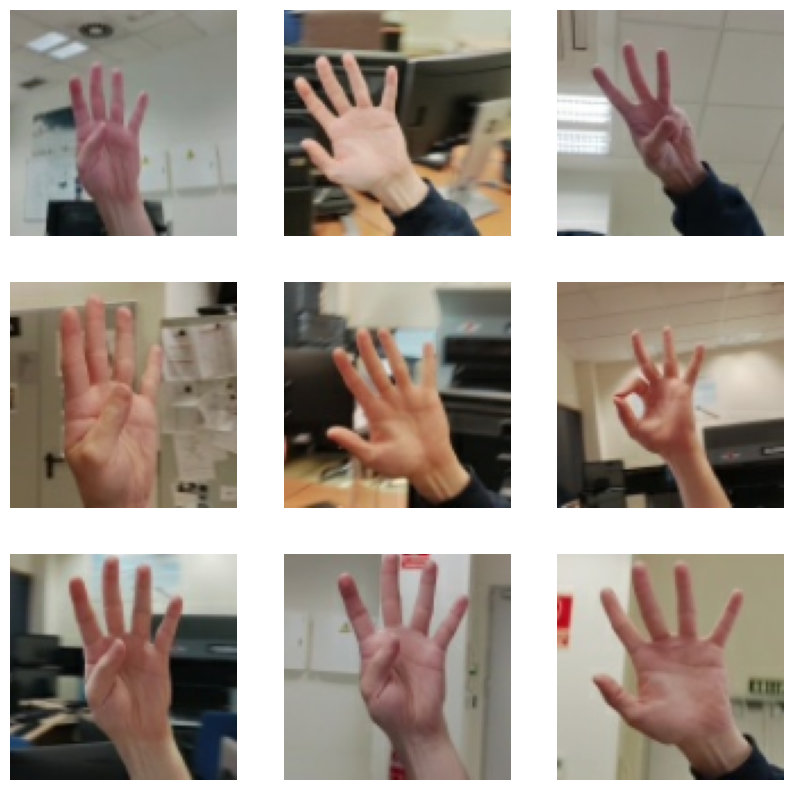

In [25]:
#Mostramos imagen de entrenamiento normalizada sin modificaciones
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  #images contiene un batch(32) de imagenes de 56x56x3
  #labels contiene un array de 32 arrays con 10 clases marcando un 1 o 0 dependiendo de la clase de cada imagen
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy()) ## usar .astype("uint8") si las imagenes van de 0 a 255 si no float 0 a 1
    #plt.title(class_names[labels[i].numpy().tolist().index(1)-2])
    plt.axis("off")

In [18]:
#Configuramos nuestra capa de data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        #tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomBrightness((-0.3,0.3),value_range=(0,1)),
        tf.keras.layers.RandomTranslation(0.05, 0.2),
        #tf.keras.layers.RandomCrop(25,25),
        #tf.keras.layers.RandomContrast(0.3)
    ]
)
data_augmentation.build((None, image_side, image_side, 3)) ## this is important to prevent usage of data augmentation change his shape

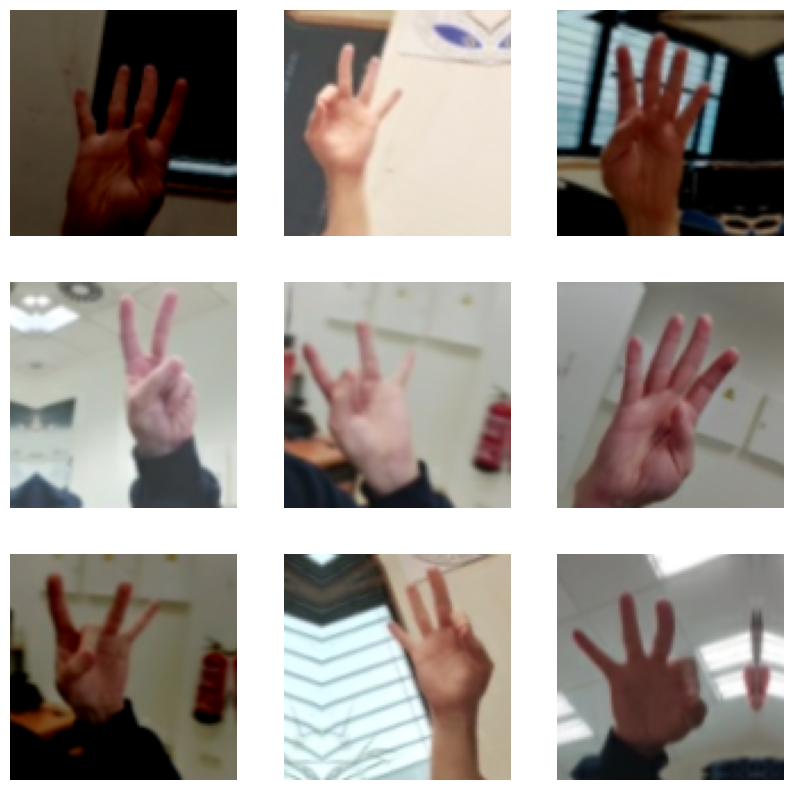

In [30]:
#probamos nuestro data augmentation
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  #images contiene un batch(32) de imagenes de 56x56x3
  #labels contiene un array de 32 arrays con 10 clases marcando un 1 o 0 dependiendo de la clase de cada imagen
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(images[i].numpy())) ## usar .astype("uint8") si las imagenes van de 0 a 255 si no float 0 a 1
    #plt.title(class_names[labels[i].numpy().tolist().index(1)-2])
    plt.axis("off")

In [50]:
# VGG19
# Importamos el modelo base que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(image_side, image_side, 3),
                                          include_top=False,
                                          weights='imagenet')

#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[1:6]:
  layer.trainable = False

##DEFINIMOS EL MODELO



# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Data augmentation
model.add(data_augmentation)
data_augmentation.summary()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)
VGG19_model.summary()




# Continuamos añadiendo más capas que sí serán entrenadas...
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(len(class_names), activation = 'softmax'))

model.build((None, image_side, image_side, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 100, 100, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 100, 100, 3)       0         
 ation)                                                          
                                                                 
 random_brightness (RandomB  (None, 100, 100, 3)       0         
 rightness)                                                      
                                                                 
 random_translation (Random  (None, 100, 100, 3)       0         
 Translation)                                                    
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
________________________

In [51]:
## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy",
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback para guardar checkpoints y modificar el learning rate dinamicamente
#checkpointer = ModelCheckpoint(filepath='model', verbose=1, save_best_only=True,
#                               monitor = 'val_accuracy', mode = 'max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                              patience=3, min_lr=0.000001)

history = model.fit(train_ds,validation_data = validation_ds,
                             callbacks = [
#                                 reduce_lr,
#                                 checkpointer
                                ],
                   epochs=epochs)

Epoch 1/25


276/276 [==============================] - 10s 30ms/step - loss: 2.8616 - accuracy: 0.4747 - val_loss: 4.4339 - val_accuracy: 0.1445
Epoch 2/25
276/276 [==============================] - 8s 30ms/step - loss: 2.0828 - accuracy: 0.7266 - val_loss: 4.3917 - val_accuracy: 0.2313
Epoch 3/25
276/276 [==============================] - 8s 30ms/step - loss: 1.7176 - accuracy: 0.8391 - val_loss: 3.1222 - val_accuracy: 0.3986
Epoch 4/25
276/276 [==============================] - 8s 30ms/step - loss: 1.5167 - accuracy: 0.9020 - val_loss: 7.0743 - val_accuracy: 0.1756
Epoch 5/25
276/276 [==============================] - 8s 30ms/step - loss: 1.3927 - accuracy: 0.9385 - val_loss: 3.5107 - val_accuracy: 0.4224
Epoch 6/25
276/276 [==============================] - 8s 30ms/step - loss: 1.3422 - accuracy: 0.9523 - val_loss: 3.6069 - val_accuracy: 0.3768
Epoch 7/25
276/276 [==============================] - 8s 30ms/step - loss: 1.2848 - accuracy: 0.9671 - val_loss: 3.1890 - val_accuracy: 0.4733
Epoch 8/2

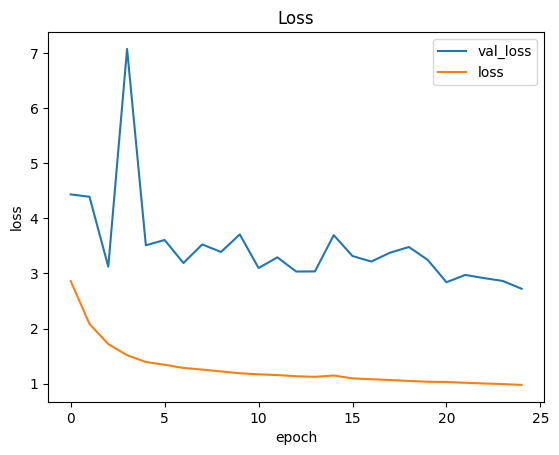

In [52]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['val_loss','loss'])
plt.show()

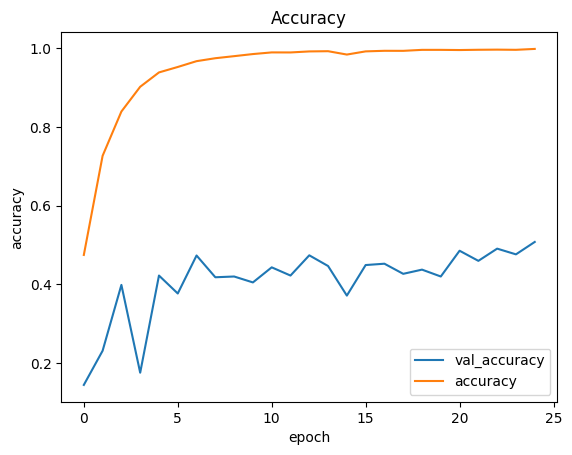

In [53]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['val_accuracy','accuracy'])
plt.show()

In [ ]:
model.save(MODEL_SAVE_PATH)

In [28]:
## load model from zero
model = tf.keras.models.load_model("../TrainedModels/numbers_model_100x100_70pc.keras")

In [38]:
model.evaluate(validation_ds)

65/65 [==============================] - 1s 13ms/step - loss: 1.4106 - accuracy: 0.6232


[1.4105890989303589, 0.6231814026832581]

In [39]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("normalized")
  else:
    print("without normalization")

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() /2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, format(cm[i,j],fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

import numpy as np

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
print(predicted_labels)



1/1 [==============================] - 0s 90ms/step
tf.Tensor([4 4 6 ... 4 0 7], shape=(2062,), dtype=int64)


In [40]:
final_correct_labels = []
for lb in correct_labels:
  itlist=list(lb.numpy())
  final_correct_labels.append(itlist.index(1.0))

In [41]:

cm = confusion_matrix(predicted_labels, final_correct_labels)

without normalization
[[200   0   0   0   0   0   0   0   0   0]
 [  0  59   1   0   0   0   0   0   1   0]
 [  0 140 145   7   0   0   0  25  41   8]
 [  0   5  19 179   0   0   0   0  11   1]
 [  0   0   0   1 191  27 108  38  24  24]
 [  0   0   0   2   2 180   1   0   0   1]
 [  0   0  28   1  11   0  94  52  16  20]
 [  0   0   3   5   0   0   2  83  63   0]
 [  0   0   0   1   0   0   0   0   4   0]
 [  5   2  10  10   3   0   2   8  48 150]]


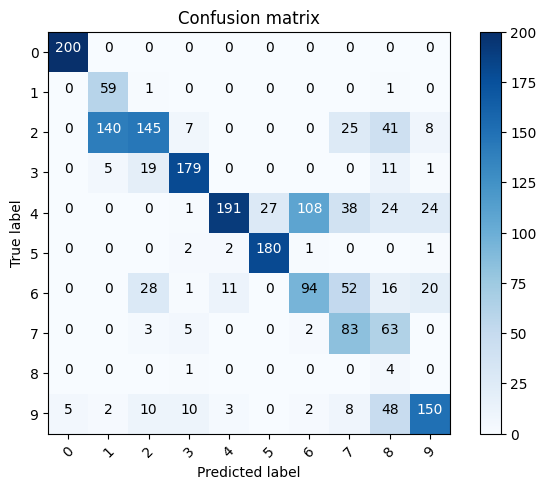

In [42]:
plot_confusion_matrix(cm,class_names)